In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

### PGD

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msup>
    <mi>x</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
      <mo>+</mo>
      <mn>1</mn>
    </mrow>
  </msup>
  <mo>=</mo>
  <msub>
    <mi mathvariant="normal">&#x3A0;</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>x</mi>
      <mo>+</mo>
      <mi>S</mi>
    </mrow>
  </msub>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>x</mi>
    <mi>t</mi>
  </msup>
  <mo>+</mo>
  <mi>&#x3B1;</mi>
  <mi>s</mi>
  <mi>g</mi>
  <mi>n</mi>
  <mo stretchy="false">(</mo>
  <msub>
    <mo>&#x25BD;</mo>
    <mi>x</mi>
  </msub>
  <mi>L</mi>
  <mo stretchy="false">(</mo>
  <mi>&#x3B8;</mi>
  <mo>,</mo>
  <mi>x</mi>
  <mo>,</mo>
  <mi>y</mi>
  <mo stretchy="false">)</mo>
  <mo stretchy="false">)</mo>
  <mo stretchy="false">)</mo>
</math>

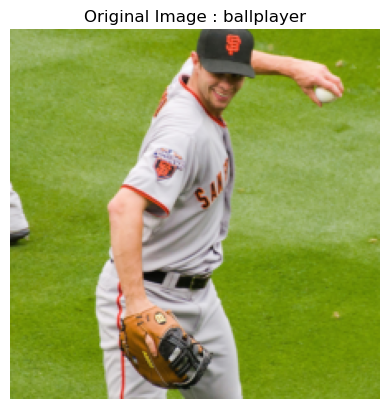

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

class_idx = json.load(open("../data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image = "../data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device) # (N,C,H,W) - N = batchsize 추가

output = model(image_tensor)

# print(output.shape)

_, predict = torch.max(output, 1)

# print(predict)

# print(predict.item())

labels = idx2label[predict.item()]

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy() # (C,H,W) -> (H,W,C)
original_image = np.clip(original_image, a_min=0,a_max=1)

plt.imshow(original_image)
plt.axis("off")
plt.title(f"Original Image : {labels}")
plt.show()

In [29]:
def pgd(image, labels, model, loss_fn, alpha, iters, epsilon):
    
    original_image = image.clone().detach()

    for i in tqdm(range(iters), desc="pgd attack"):
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()

        with torch.no_grad(): 
            adversarial_image = image + alpha*image.grad.sign()

            image = torch.clamp(image, 0, 1)

            # 원본 이미지와 크게 달라지지 않는 범위 내에서만 변화가 발생하도록 -> stealthiness
            image = torch.max(torch.min(image, original_image + epsilon), original_image - epsilon) 

        image = image.detach() # 그래디언트 추적 중지

    return adversarial_image
    
alpha=2/255
iters=100
epsilon=0.03
loss_fn = nn.CrossEntropyLoss()

adversarial_image = pgd(image_tensor, predict, model, loss_fn, alpha, iters, epsilon)

# print(adversarial_image)

# print(adversarial_image.shape)

pgd attack: 100%|██████████| 100/100 [00:01<00:00, 78.19it/s]


racket


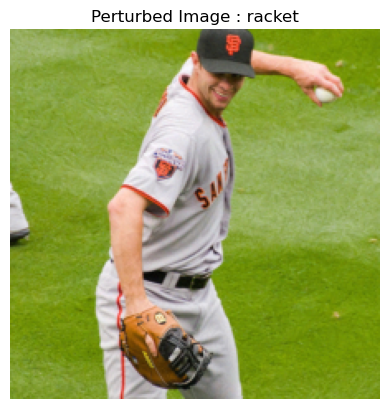

In [30]:
adversarial_output = model(adversarial_image)

_, adversarial_predict = torch.max(adversarial_output, 1)

adversarial_labels = idx2label[adversarial_predict.item()]

print(adversarial_labels)

perturbed_image = adversarial_image.squeeze(0).permute(1,2,0).detach().cpu().numpy()
perturbed_image = np.clip(perturbed_image, 0, 1)

plt.imshow(perturbed_image)
plt.axis("off")
plt.title(f"Perturbed Image : {adversarial_labels}")
plt.show()